<a href="https://colab.research.google.com/github/oliveiraprg/text-summarization-with-python/blob/main/algoritimo_de_luhn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sumarização de textos com o Algoritimo de Luhn 



*  [ https://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf](https://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf)




## Preparação do texto de exemplo

In [1]:
import re
import nltk
import numpy
import string
import heapq

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
texto_original = """A inteligência artificial é a inteligência similar à humana máquinas.
                    Definem como o estudo de agente artificial com inteligência.
                    Ciência e engenharia de produzir máquinas com inteligência.
                    Resolver problemas e possuir inteligência. 
                    Relacionada ao comportamento inteligente. 
                    Construção de máquinas para raciocinar. 
                    Aprender com os erros e acertos. 
                    Inteligência artificial é raciocinar nas situações do cotidiano."""

In [5]:
texto_original = re.sub(r'\s+', ' ', texto_original)

In [6]:
stop_words = nltk.corpus.stopwords.words('portuguese')

In [91]:
stop_words.append('ser')
stop_words.append('além')

In [25]:
def pre_processamento(texto):
  texto_formatado = texto.lower()
  tokens = []
  for token in nltk.word_tokenize(texto_formatado):
    tokens.append(token)
  tokens = [palavra for palavra in tokens if palavra not in stop_words and palavra not in string.punctuation]
  texto_formatado = ' '.join([str(elemento) for elemento in tokens if not elemento.isdigit()])
  return texto_formatado

## Função para calcular a nota das sentenças

In [33]:
def calcula_nota_sentenca(sentencas, palavras_importantes, distancia):
  notas = []
  indice_sentenca = 0

  for sentenca in [nltk.word_tokenize(sentenca.lower()) for sentenca in sentencas]:
    indice_palavra = []
    for palavra in palavras_importantes:
      try:
        indice_palavra.append(sentenca.index(palavra))
      except ValueError:
        pass
    indice_palavra.sort()
    if len(indice_palavra) == 0:continue  
    lista_grupos = []
    grupo_palavras = [indice_palavra[0]]
    i = 1
    while i < len(indice_palavra):
      if indice_palavra[i] - indice_palavra[i-1] < distancia:
        grupo_palavras.append(indice_palavra[i])
      else:
        lista_grupos.append(grupo_palavras[:])
        grupo_palavras = [indice_palavra[i]]
      i += 1
    lista_grupos.append(grupo_palavras)
    nota_maxima_grupo = 0
    for grupo in lista_grupos:
      palavras_importantes_no_grupo = len(grupo)
      total_palavras_no_grupo = grupo[-1] - grupo[0] + 1
      nota = 1.0 * palavras_importantes_no_grupo**2 / total_palavras_no_grupo
      if nota > nota_maxima_grupo:
        nota_maxima_grupo = nota
    notas.append((nota_maxima_grupo, indice_sentenca))
    indice_sentenca += 1
  return notas


## Função para sumarizar os textos

In [53]:
def sumarizar(texto, distancia):
  sentencas_originais = [sentenca for sentenca in nltk.sent_tokenize(texto)]
  sentencas_formatadas = [pre_processamento(sentenca_original) for sentenca_original in sentencas_originais]
  palavras = [palavra for sentenca in sentencas_formatadas for palavra in nltk.word_tokenize(sentenca)]
  top_n_palavras = int(len(palavras) / 4) 
  frequencia = nltk.FreqDist(palavras)
  quantidade_sentencas = int(len(sentencas_originais) / 2)
  top_n_palavras = [palavra[0] for palavra in frequencia.most_common(top_n_palavras)]
  calcula_nota_sentenca(sentencas_formatadas, top_n_palavras, distancia)
  notas_sentencas = calcula_nota_sentenca(sentencas_formatadas, top_n_palavras, distancia)
  melhores_sentencas = heapq.nlargest(quantidade_sentencas, notas_sentencas)
  melhores_sentencas = [sentencas_originais[i] for (nota, i) in melhores_sentencas]
  return sentencas_originais, melhores_sentencas, notas_sentencas

In [54]:
sentencas_originais, melhores_sentencas, notas_sentencas = sumarizar(texto_original, 5)

In [55]:
sentencas_originais, melhores_sentencas, notas_sentencas

(['A inteligência artificial é a inteligência similar à humana máquinas.',
  'Definem como o estudo de agente artificial com inteligência.',
  'Ciência e engenharia de produzir máquinas com inteligência.',
  'Resolver problemas e possuir inteligência.',
  'Relacionada ao comportamento inteligente.',
  'Construção de máquinas para raciocinar.',
  'Aprender com os erros e acertos.',
  'Inteligência artificial é raciocinar nas situações do cotidiano.'],
 ['A inteligência artificial é a inteligência similar à humana máquinas.',
  'Definem como o estudo de agente artificial com inteligência.',
  'Construção de máquinas para raciocinar.',
  'Relacionada ao comportamento inteligente.'],
 [(4.166666666666667, 0), (3.2, 1), (2.0, 2), (1.0, 3), (2.0, 4), (3.0, 5)])

## Visualização do resumo

In [56]:
def visualiza_resumo(titulo, lista_sentencas, melhores_sentencas):
  from IPython.core.display import HTML
  texto = ''
  resumo = ''
  display(HTML(f'<h1>{titulo}</h1>'))
  display(HTML(f'<h2>Texto com resumo destacado - {titulo}</h2>'))
  for sentenca in lista_sentencas:
    if sentenca in melhores_sentencas:
      texto += str(sentenca).replace(sentenca, f'<mark>{sentenca} </mark>')
      resumo += str(sentenca).replace(sentenca, f'{sentenca} ')
    else:
      texto += f'{sentenca} '
  display(HTML(f'{texto}'))
  display(HTML(f'<h2>Resumo de - {titulo}</h2>'))
  display(HTML(f'{resumo}'))

In [57]:
visualiza_resumo('Inteligência Artificial', sentencas_originais, melhores_sentencas)

## Extração de texto da internet

In [58]:
!pip install goose3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
from goose3 import Goose

In [60]:
g = Goose()
url = 'https://iaexpert.academy/2020/11/09/ia-preve-resultado-das-eleicoes-americanas/'
artigo = g.extract(url)

In [61]:
artigo.cleaned_text

'Nas eleições presidenciais americanas de 2016, a maioria das predições apontavam para a vitória de Hillary Clinton. Entretanto, a história nos mostrou o resultado oposto, e Donald Trump foi o presidente nos últimos 4 anos. Desta vez, os estatísticos reexaminaram seus modelos, para aumentar o grau de confiabilidade nos seus resultados. Nesta tentativa de otimização das predições, a inteligência artificial certamente não ficou de fora.\n\nO modelo desenvolvido pelo Dr. Hernan Makse, físico estatístico da Universidade da Cidade de Nova York, baseou suas predições em uma rede neural treinada para processar os sentimentos expressos nas redes sociais. O algoritmo fez a análise de cerca de 1 bilhão de tweets para chegar a uma estimativa dos resultados do pleito. No dia da eleição, 3 de novembro, o modelo estava indicando a vitória de Joe Biden.\n\nO Dr. Makse disse que seu trabalho começou já na eleição de 2016, e foi testado novamente nas eleições na Argentina ano passado. Desta vez, o mode

In [62]:
sentencas_originais, melhores_sentencas, notas_sentencas = sumarizar(artigo.cleaned_text, 5)

In [63]:
sentencas_originais, melhores_sentencas, notas_sentencas

(['Nas eleições presidenciais americanas de 2016, a maioria das predições apontavam para a vitória de Hillary Clinton.',
  'Entretanto, a história nos mostrou o resultado oposto, e Donald Trump foi o presidente nos últimos 4 anos.',
  'Desta vez, os estatísticos reexaminaram seus modelos, para aumentar o grau de confiabilidade nos seus resultados.',
  'Nesta tentativa de otimização das predições, a inteligência artificial certamente não ficou de fora.',
  'O modelo desenvolvido pelo Dr. Hernan Makse, físico estatístico da Universidade da Cidade de Nova York, baseou suas predições em uma rede neural treinada para processar os sentimentos expressos nas redes sociais.',
  'O algoritmo fez a análise de cerca de 1 bilhão de tweets para chegar a uma estimativa dos resultados do pleito.',
  'No dia da eleição, 3 de novembro, o modelo estava indicando a vitória de Joe Biden.',
  'O Dr. Makse disse que seu trabalho começou já na eleição de 2016, e foi testado novamente nas eleições na Argentina

In [64]:
visualiza_resumo(artigo.title, sentencas_originais, melhores_sentencas)

## Leitura de artigo de feeds de noticias(RSS)

In [67]:
!pip install feedparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 4.0 MB/s 
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=0e1f9c022966efc54a615c2f72b67dda86ced3142a18eb90ccbe08e96f24d45d
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36cebfdddfe059f50e019aa
Successfully built sgmllib3k


In [68]:
import feedparser

In [70]:
from bs4 import BeautifulSoup
import os
import json

In [71]:
url = 'https://iaexpert.academy/feed/'
feed = feedparser.parse(url)

In [72]:
feed.entries

[{'title': 'Como usar a plataforma IA Expert',
  'title_detail': {'type': 'text/plain',
   'language': None,
   'base': 'https://iaexpert.academy/feed/',
   'value': 'Como usar a plataforma IA Expert'},
  'links': [{'rel': 'alternate',
    'type': 'text/html',
    'href': 'https://iaexpert.academy/2022/10/04/como-usar-a-plataforma-ia-expert/?utm_source=rss&utm_medium=rss&utm_campaign=como-usar-a-plataforma-ia-expert'}],
  'link': 'https://iaexpert.academy/2022/10/04/como-usar-a-plataforma-ia-expert/?utm_source=rss&utm_medium=rss&utm_campaign=como-usar-a-plataforma-ia-expert',
  'comments': 'https://iaexpert.academy/2022/10/04/como-usar-a-plataforma-ia-expert/#respond',
  'authors': [{'name': 'Jones Granatyr'}],
  'author': 'Jones Granatyr',
  'author_detail': {'name': 'Jones Granatyr'},
  'published': 'Tue, 04 Oct 2022 10:00:00 +0000',
  'published_parsed': time.struct_time(tm_year=2022, tm_mon=10, tm_mday=4, tm_hour=10, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=277, tm_isdst=0),
  'tags'

In [76]:
for elemento in feed.entries:
  print(elemento.title)
  print(elemento.links[0]['href'])
  print(elemento.content[0].value)

Como usar a plataforma IA Expert
https://iaexpert.academy/2022/10/04/como-usar-a-plataforma-ia-expert/?utm_source=rss&utm_medium=rss&utm_campaign=como-usar-a-plataforma-ia-expert
<p class="wp-embed-aspect-4-3 wp-has-aspect-ratio">Nesse vídeo, você confere como funciona o acesso a plataforma IA Expert. Aprenda a fazer pesquisa e inscrição nos cursos, alteração de senha, download do certificado de conclusão e muito mais!</p>



<p class="wp-embed-aspect-4-3 wp-has-aspect-ratio">Torne-se <a href="https://iaexpert.academy/assinatura" rel="noreferrer noopener" target="_blank">assinante</a> IA Expert Academy.</p>



<figure class="wp-block-embed"><div class="wp-block-embed__wrapper">
<div class="ast-oembed-container"></div>
</div></figure>
Introdução ao Data Robot para Machine Learning
https://iaexpert.academy/2022/09/29/introducao-ao-data-robot-para-machine-learning/?utm_source=rss&utm_medium=rss&utm_campaign=introducao-ao-data-robot-para-machine-learning
<p class="wp-embed-aspect-4-3 wp-ha

In [77]:
def limpa_html(texto):
  if texto == '':
    return ''
  return BeautifulSoup(texto, 'html5lib').get_text()

In [78]:
limpa_html(elemento.content[0].value)

'Veja nesta aula o conteúdo do curso “Machine Learning sem Código e sem Matemática“. \n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\n\n\n'

In [79]:
artigos = []
for artigo in feed.entries:
  artigos.append({'titulo': artigo.title, 'conteudo': limpa_html(artigo.content[0].value)})

In [80]:
artigos

[{'titulo': 'Como usar a plataforma IA Expert',
  'conteudo': 'Nesse vídeo, você confere como funciona o acesso a plataforma IA Expert. Aprenda a fazer pesquisa e inscrição nos cursos, alteração de senha, download do certificado de conclusão e muito mais!\n\n\n\nTorne-se assinante IA Expert Academy.\n\n\n\n\n\n'},
 {'titulo': 'Introdução ao Data Robot para Machine Learning',
  'conteudo': 'Veja nesta aula noções introdutórias sobre o Data Robot para Machine Learning. A aula faz parte do curso “Machine Learning sem Código e sem Matemática”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\n\n\n'},
 {'titulo': 'OpenAI apresenta Whisper, sistema de transcrição de áudio com desempenho humano',
  'conteudo': 'Apesar de todo o progresso recente na área de processamento de linguagem natural, as tarefas mais beneficiadas foram aquelas associadas a sistemas de conversação, onde o usuário poderia interagir com a inteligência artificial no formato de texto. A transcrição de

In [83]:
arquivo_gravar = os.path.join('feed_iaexpert.json')
arquivo = open(arquivo_gravar, 'w+')
arquivo.write(json.dumps(artigos, indent=1))
arquivo.close()

In [85]:
artigos_blog = json.loads(open('/content/feed_iaexpert.json').read())
artigos_blog

[{'titulo': 'Como usar a plataforma IA Expert',
  'conteudo': 'Nesse vídeo, você confere como funciona o acesso a plataforma IA Expert. Aprenda a fazer pesquisa e inscrição nos cursos, alteração de senha, download do certificado de conclusão e muito mais!\n\n\n\nTorne-se assinante IA Expert Academy.\n\n\n\n\n\n'},
 {'titulo': 'Introdução ao Data Robot para Machine Learning',
  'conteudo': 'Veja nesta aula noções introdutórias sobre o Data Robot para Machine Learning. A aula faz parte do curso “Machine Learning sem Código e sem Matemática”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\n\n\n'},
 {'titulo': 'OpenAI apresenta Whisper, sistema de transcrição de áudio com desempenho humano',
  'conteudo': 'Apesar de todo o progresso recente na área de processamento de linguagem natural, as tarefas mais beneficiadas foram aquelas associadas a sistemas de conversação, onde o usuário poderia interagir com a inteligência artificial no formato de texto. A transcrição de

## Nuvem de palavras

In [92]:
conteudo_feed = ''
for artigo in artigos_blog:
  conteudo_feed += artigo['conteudo']

In [93]:
conteudo_feed

'Nesse vídeo, você confere como funciona o acesso a plataforma IA Expert. Aprenda a fazer pesquisa e inscrição nos cursos, alteração de senha, download do certificado de conclusão e muito mais!\n\n\n\nTorne-se assinante IA Expert Academy.\n\n\n\n\n\nVeja nesta aula noções introdutórias sobre o Data Robot para Machine Learning. A aula faz parte do curso “Machine Learning sem Código e sem Matemática”.\n\n\n\nO curso está disponível para assinantes IA Expert Academy.\n\n\n\n\n\nApesar de todo o progresso recente na área de processamento de linguagem natural, as tarefas mais beneficiadas foram aquelas associadas a sistemas de conversação, onde o usuário poderia interagir com a inteligência artificial no formato de texto. A transcrição de áudio para texto teve desenvolvimento mais lento, e apesar de várias ferramentas já produzirem legendas automaticamente, a qualidade ainda não estava a par dos sistemas conversacionais.\n\n\n\nNa última semana, a OpenAI mudou este paradigma ao disponibiliz

In [94]:
conteudo_feed_formatado = pre_processamento(conteudo_feed)
conteudo_feed_formatado

'nesse vídeo confere funciona acesso plataforma ia expert aprenda fazer pesquisa inscrição cursos alteração senha download certificado conclusão torne-se assinante ia expert academy veja nesta aula noções introdutórias sobre data robot machine learning aula faz parte curso “ machine learning código matemática ” curso disponível assinantes ia expert academy apesar todo progresso recente área processamento linguagem natural tarefas beneficiadas associadas sistemas conversação onde usuário poderia interagir inteligência artificial formato texto transcrição áudio texto desenvolvimento lento apesar várias ferramentas produzirem legendas automaticamente qualidade ainda par sistemas conversacionais última semana openai mudou paradigma disponibilizar formato aberto código whisper rede neural treinada tarefa transcrição áudio arquitetura modelo segue abordagem to tipo end-to-end onde encoder aprende codificar áudio decoder aprende converter sinal texto durante processamento áudio entrada fragme

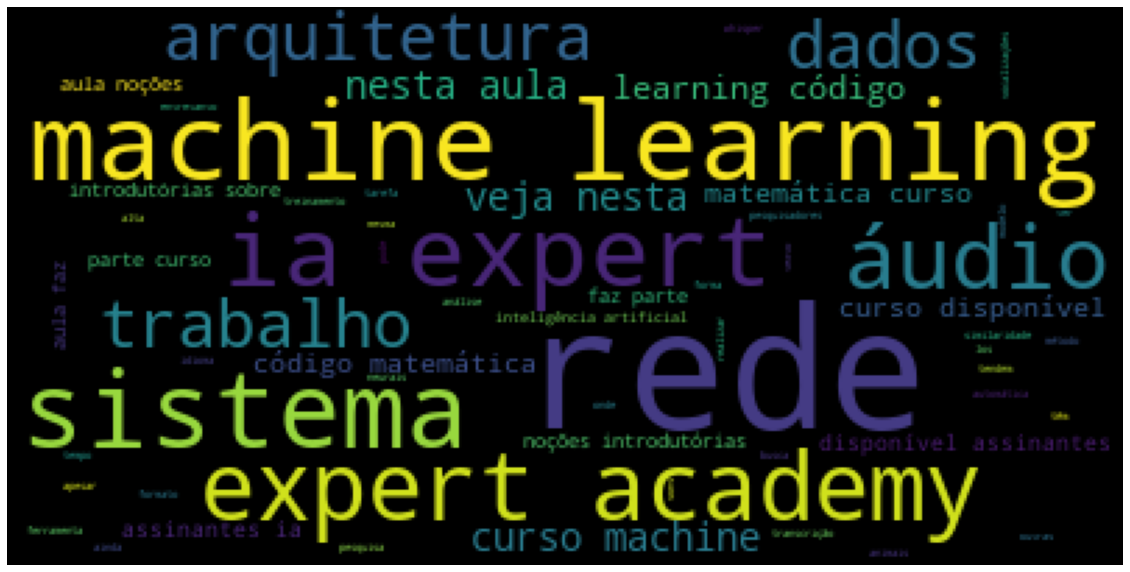

In [95]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(WordCloud().generate(conteudo_feed_formatado))